# ENV/ATM 415: Climate Laboratory

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 10: Climate sensitivity and feedback

____________
<a id='section1'></a>

## 1. Radiative forcing
____________

We've seen the concept of Radiative Forcing before. It is the short-term change in the TOA energy budget when we add a forcing agent to the climate system, **before the surface has a chance to warm up**.

The standard reference forcing is a **doubling of atmospheric CO$_2$**. 

The **radiative forcing** is a number in W m$^{-2}$, defined so that it is **positive if the system is gaining energy**:

$$ \Delta R = \left(\text{ASR}_{2xCO2} - \text{OLR}_{2xCO2}\right) - \left(\text{ASR}_{ref} - \text{OLR}_{ref}\right)$$

$\Delta R$ is a measure of the rate at which energy begins to accumulate in the climate system after an abrupt increase in greenhouse gases, but *before any change in climate* (i.e. temperature).

### Radiative forcing in a single-column model

Let's set up a single-column Radiative-Convective model and look carefully at what happens when we add extra CO$_2$ to the column.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from metpy.plots import SkewT

In [2]:
#  Get the observed air temperature
# The NOAA ESRL server is shutdown! January 2019
#temperature_filename = 'air.mon.1981-2010.ltm.nc'  # temperature
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
#ncep_air = xr.open_dataset(ncep_url + temperature_filename, decode_times=False)
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/pressure/air'
air = xr.open_dataset(url)
# The name of the vertical axis is different than the NOAA ESRL version..
ncep_air = air.rename({'lev': 'level'})
#  Take global, annual average 
weight = np.cos(np.deg2rad(ncep_air.lat)) / np.cos(np.deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

In [3]:
#  Get the water vapor data
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr, decode_times=False)
Qglobal = ((atm_control.Q * atm_control.gw)/atm_control.gw.mean(dim='lat')).mean(dim=('lat','lon','time'))

In [4]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=state,
                                               adj_lapse_rate=6.5,
                                               timestep=rad.timestep,)
rcm = rad + conv
rcm.name = 'Radiative-Convective Model'

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [5]:
print(rcm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiative-Convective Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



First let's take a look at the default CO$_2$ amount in our reference model:

In [6]:
rcm.subprocess['Radiation'].absorber_vmr['CO2']

0.000348

That's 348 parts per million (ppm). Our atmosphere was at this level around the late 1980s.

Before we can look at the effects of a CO2 perturbation we need to integrate our reference model out to equilibrium:

In [7]:
rcm.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


Are we close to energy balance?

In [8]:
rcm.ASR - rcm.OLR

Field([-3.12861513e-06])

### Clone the model and perturb CO2

In [9]:
# Make an exact clone with same temperatures
rcm_2xCO2 = climlab.process_like(rcm)
rcm_2xCO2.name = 'Radiative-Convective Model (2xCO2 initial)'

In [10]:
#  Check to see that we indeed have the same CO2 amount
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2']

0.000348

In [11]:
#  Now double it!
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2

In [12]:
#  and verify
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2']

0.000696

### Instantaneous radiative forcing

The simplest measure of radiative forcing is **the instantaneous change** in the energy budget **before the temperature have a chance to adjust**.

To get this we need to call the `compute_diagnostics` method, but not any forward timestep.

In [13]:
rcm_2xCO2.compute_diagnostics()

Now take a look at the changes in the SW and LW budgets:

In [14]:
rcm_2xCO2.ASR - rcm.ASR

Field([0.06281552])

In [15]:
rcm_2xCO2.OLR - rcm.OLR

Field([-2.11372722])

So what is instantaneous radiative forcing for the doubling of CO2?

In [16]:
DeltaR_instant = (rcm_2xCO2.ASR - rcm_2xCO2.OLR) - (rcm.ASR - rcm.OLR)
DeltaR_instant

Field([2.17654274])

The radiative forcing for a doubling of CO2 in this model is 2.18 W m$^{-2}$.

As we can see above, almost all of the radiative forcing appears in the longwave. We have made the atmosphere **more optically thick** by adding CO$_2$.

Think about this the same way we increased the absorptivity / emissivity parameter $\epsilon$ in the simple grey-gas model.

### Statosphere-adjusted radiative forcing

The point of measuring radiative forcing is that it should give us some information about how much global warming we should expect from a particular forcing agent.

We will need to use our model to quantify the **eventual** temperature change associated with this forcing.

It turns out, for reasons we won't get into here, that a more useful measure of the global warming impact of a forcing agent comes from thinking about **changes in radiative flux at the tropopause** rather than the Top of Atmosphere.

The idea here is that we will **let the stratosphere adjust to the extra CO$_2$** while **holding the troposphere and surface temperatures fixed**.

In this model levels 0 through 12 are in the statosphere; levels 13 and larger are in the troposphere:

In [17]:
rcm.lev[13:]

array([226.513265, 266.481155, 313.501265, 368.81798 , 433.895225,
       510.455255, 600.5242  , 696.79629 , 787.70206 , 867.16076 ,
       929.648875, 970.55483 , 992.5561  ])

So to compute stratosphere-adjusted forcing, we'll timestep the model, but continually reset the temperatures to their reference values below 226 hPa:

In [18]:
rcm_2xCO2_strat = climlab.process_like(rcm_2xCO2)
rcm_2xCO2_strat.name = 'Radiative-Convective Model (2xCO2 stratosphere-adjusted)'
for n in range(1000):
    rcm_2xCO2_strat.step_forward()
    # hold tropospheric and surface temperatures fixed
    rcm_2xCO2_strat.Tatm[13:] = rcm.Tatm[13:]
    rcm_2xCO2_strat.Ts[:] = rcm.Ts[:]

Now we can compute the stratosphere-adjusted radiative forcing for the doubling of CO2:

In [19]:
DeltaR = (rcm_2xCO2_strat.ASR - rcm_2xCO2_strat.OLR) - (rcm.ASR - rcm.OLR)
DeltaR

Field([4.28716552])

The result is about 4.3 W m$^{-2}$.

____________

<a id='section2'></a>

## 2. Equilibrium climate sensitivity (without feedback)
____________


We now ask the question: How much warming will we get (eventually) in response to this positive radiative forcing?

We define the **Equilibrium Climate Sensitivity** (denoted **ECS** or $\Delta T_{2xCO2}$):

*The global mean surface warming necessary to balance the planetary energy budget after a doubling of atmospheric CO$_2$.*

We can go ahead and calculate ECS in our single-column model:

In [20]:
rcm_2xCO2_eq = climlab.process_like(rcm_2xCO2_strat)
rcm_2xCO2_eq.name = 'Radiative-Convective Model (2xCO2 equilibrium)'
rcm_2xCO2_eq.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 12.736753858124827 years.


In [21]:
# are we close to equilibrium?
rcm_2xCO2_eq.ASR - rcm_2xCO2_eq.OLR

Field([5.94013727e-12])

Let's follow what we have done before and plot the results on a nice Skew-T:

In [22]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

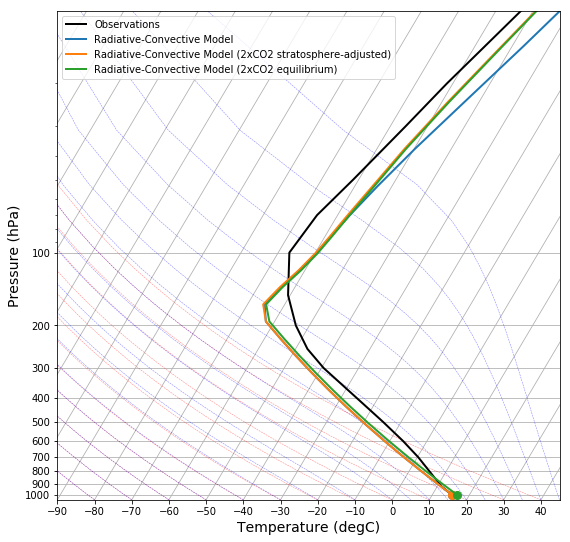

In [23]:
skew = make_skewT()
add_profile(skew, rcm)
add_profile(skew, rcm_2xCO2_strat)
add_profile(skew, rcm_2xCO2_eq)

What do you see here? What has changed?

### Calculate the ECS

It is just the difference in surface temperature:

In [24]:
ECS_nofeedback = rcm_2xCO2_eq.Ts - rcm.Ts
ECS_nofeedback

Field([1.3008774])

Doubling CO$_2$ in this model causes about 1.3 K of warming at equilibrium.

What about the energy budget? 

Remember that we have let the model warm up to its new equilibrium! 

If we look at the differences between the two equilibrium states (before and after doubling CO$_2$), we find only very small and offsetting changes in SW and LW:

In [25]:
rcm_2xCO2_eq.OLR - rcm.OLR

Field([0.05158323])

In [26]:
rcm_2xCO2_eq.ASR - rcm.ASR

Field([0.05158635])

The 1.3 K sensitivity we've just calculated is the warming that we would have *if there were no other changes (feedbacks) in response to the CO$_2$ induced warming!*

### The no-feedback response

We have just calculated an equilibrium warming $\Delta T_0$ (in K) resulting from a radiative forcing $\Delta R$ (in W m$^{-2}$) for a model without feedback.

Let's define the **no-feedback climate response parameter** $\lambda_0$ as

$$ \lambda_0 = \frac{\Delta R}{\Delta T_0 } $$

With the numbers we came up with above,

In [27]:
lambda0 = DeltaR / ECS_nofeedback
lambda0

Field([3.29559537])

The no-feedback climate response parameter is $\lambda_0 = 3.3$ W m$^{-2}$ K$^{-1}$.

What are some important processes that our model has neglected?

____________
<a id='section3'></a>

## 3. The feedback concept
____________

A concept borrowed from electrical engineering. You have all heard or used the term before, but we’ll try take a more precise approach today.

A feedback occurs when a portion of the output from the action of a system is added to the input and subsequently alters the output:

<img src="http://www.atmos.albany.edu/facstaff/brose/classes/ENV415_Spring2018/images/feedback_sketch.png" width="500">


The result of a loop system can either be **amplification** or **dampening** of the process, depending on the sign of the gain in the loop, which we will denote $f$.

We will call amplifying feedbacks **positive** ($f>0$) and damping feedbacks **negative** ($f<0$).

We can think of the “process” here as the entire climate system, which contains many examples of both positive and negative feedback.

### Example: the water vapor feedback

The capacity of the atmosphere to hold water vapor (saturation specific humidity) increases exponentially with temperature. Warming is thus accompanied by moistening (more water vapor), which leads to more warming due to the enhanced water vapor greenhouse effect.

**Positive or negative feedback?**

### Example: the ice-albedo feedback

Colder temperatures lead to expansion of the areas covered by ice and snow, which tend to be more reflective than water and vegetation. This causes a reduction in the absorbed solar radiation, which leads to more cooling. 

**Positive or negative feedback?**

*Make sure it’s clear that the sign of the feedback is the same whether we are talking about warming or cooling.*

_____________
<a id='section4'></a>
## 4. Climate feedback: some definitions
____________

We start with an initial radiative forcing , and get a response
$$ \Delta T_0 = \frac{\Delta R}{\lambda_0} $$



Now consider what happens in the presence of a feedback process. For a concrete example, let’s take the **water vapor feedback**. For every degree of warming, there is an additional increase in the greenhouse effect, and thus additional energy added to the system.

Let’s denote this extra energy as 
$$ f \lambda_0 \Delta T_0 $$

where $f$ is the **feedback amount**, a number that represents what fraction of the output gets added back to the input. $f$ must be between $-\infty$ and +1. 

For the example of the water vapor feedback, $f$ is positive (between 0 and +1) – the process adds extra energy to the original radiative forcing.

The amount of energy in the full "input" is now

$$ \Delta R + f \lambda_0 \Delta T_0 $$

or

$$ (1+f) \lambda_0 \Delta T_0 $$

But now we need to consider the next loop. A fraction $f$ of the additional energy is also added to the input, giving us

$$ (1+f+f^2) \lambda_0 \Delta T_0 $$

and we can go round and round, leading to the infinite series

$$ (1+f+f^2+f^3+ ...) \lambda_0 \Delta T_0 = \lambda_0 \Delta T_0 \sum_{n=0}^{\infty} f^n $$

Question: what happens if $f=1$?

It so happens that this infinite series has an exact solution

$$ \sum_{n=0}^{\infty} f^n = \frac{1}{1-f} $$

So the full response including all the effects of the feedback is actually

$$ \Delta T = \frac{1}{1-f} \Delta T_0 $$

This is also sometimes written as 
$$ \Delta T = g \Delta T_0 $$

where 

$$ g = \frac{1}{1-f} = \frac{\Delta T}{\Delta T_0} $$

is called the **system gain** -- the ratio of the actual warming (including all feedbacks) to the warming we would have in the absence of feedbacks.

So if the overall feedback is positive, then $f>0$ and $g>1$.

And if the overall feedback is negative?

____________
<a id='section6'></a>
## 6. Contribution of individual feedback processes to Equilibrium Climate Sensitivity
____________


Now what if we have several individual feedback processes occurring simultaneously?

We can think of individual feedback amounts $f_1, f_2, f_3, ...$, with each  representing a physically distinct mechanism, e.g. water vapor, surface snow and ice, cloud changes, etc.

Each individual process takes a fraction $f_i$ of the output and adds to the input. So the feedback amounts are additive,

$$ f = f_1 + f_2 + f_3 + ... = \sum_{i=0}^N f_i $$

This gives us a way to compare the importance of individual feedback processes!

The climate sensitivity is now

$$ \Delta T_{2xCO2} = \frac{1}{1- \sum_{i=0}^N f_i } \Delta T_0 $$

The climate sensitivity is thus **increased by positive feedback processes**, and **decreased by negative feedback processes**.

### Climate feedback parameters

We can also write this in terms of the original radiative forcing as	

$$ \Delta T_{2xCO2} = \frac{\Delta R}{\lambda_0 - \sum_{i=1}^{N} \lambda_i} $$

where

$$ \lambda_i = \lambda_0 f_i $$

known as **climate feedback parameters**, in units of W m$^{-2}$ K$^{-1}$. 

With this choice of sign conventions, $\lambda_i > 0$ for a positive feedback process.

Individual feedback parameters $\lambda_i$ are then additive, and can be compared to the no-feedback parameter $\lambda_0$.

We might decompose the net climate feedback into, for example

- longwave and shortwave processes
- cloud and non-cloud processes

These individual feedback processes may be positive or negative. This is very powerful, because we can **measure the relative importance of different feedback processes** simply by comparing their $\lambda_i$ values.

### Every climate model has a Planck feedback

Our no-feedback response parameter $\lambda_0$ is often called the **Planck feedback**.

It is not really a feedback at all.  It is the most basic and universal climate process, and is present in every climate model. It is simply an expression of the fact that a warm planet radiates more to space than a cold planet.

As we will see, our estimate of $\lambda_0 = 3.3 ~\text{W} ~\text{m}^{-2} ~\text{K}^{-1} $ is essentially the same as the Planck feedback diagnosed from complex GCMs. Most climate models (and the real climate system) have other radiative feedback processes, such that 

$$\lambda = \lambda_0 - \sum_{i=1}^{N} \lambda_i \ne \lambda_0 $$

____________
<a id='section7'></a>
## 7. Feedbacks diagnosed from complex climate models
____________

### Data from the IPCC AR5

This figure is reproduced from the recent IPCC AR5 report. It shows the feedbacks diagnosed from the various models that contributed to the assessment.

(Later in the term we will discuss how the feedback diagnosis is actually done)

See below for complete citation information.

![feedback AR5](http://www.climatechange2013.org/images/figures/WGI_AR5_Fig9-43.jpg)

**Figure 9.43** | (a) Strengths of individual feedbacks for CMIP3 and CMIP5 models (left and right columns of symbols) for Planck (P), water vapour (WV), clouds (C), albedo (A), lapse rate (LR), combination of water vapour and lapse rate (WV+LR) and sum of all feedbacks except Planck (ALL), from Soden and Held (2006) and Vial et al. (2013), following Soden et al. (2008). CMIP5 feedbacks are derived from CMIP5 simulations for abrupt fourfold increases in CO2 concentrations (4 × CO2). (b) ECS obtained using regression techniques by Andrews et al. (2012) against ECS estimated from the ratio of CO2 ERF to the sum of all feedbacks. The CO2 ERF is one-half the 4 × CO2 forcings from Andrews et al. (2012), and the total feedback (ALL + Planck) is from Vial et al. (2013).

*Figure caption reproduced from the AR5 WG1 report*

Legend:

- P: Planck feedback
- WV: Water vapor feedback
- LR: Lapse rate feedback
- WV+LR: combined water vapor plus lapse rate feedback
- C: cloud feedback
- A: surface albedo feedback
- ALL: sum of all feedback except Plank, i.e. ALL = WV+LR+C+A

Things to note:

- The models all agree strongly on the Planck feedback. 
- The Planck feedback is about $-3.3 ~\text{W} ~\text{m}^{-2} ~\text{K}^{-1} $ just like our above estimate of $\lambda_0$ (but with opposite sign convention -- watch carefully for that in the literature)
- The water vapor feedback is strongly positive in every model.
- The lapse rate feedback is something we will study later. It is slightly negative.
- For reasons we will discuss later, the best way to measure the water vapor feedback is to combine it with lapse rate feedback.
- Models agree strongly on the combined water vapor plus lapse rate feedback.

- The albedo feedback is slightly positive but rather small globally.
- By far the largest spread across the models occurs in the cloud feedback.
- Global cloud feedback ranges from slighly negative to strongly positive across the models.
- Most of the spread in the total feedback is due to the spread in the cloud feedback.
- Therefore, most of the spread in the ECS across the models is due to the spread in the cloud feedback.

____________
<a id='section8'></a>
## 8. Water vapor feedback in the radiative-convective model
____________

In nature, as in a complex GCM, water vapor tends to increase as the air temperature warms.

The main reason for this is that **the saturation specific humidity** (i.e. how much water vapor the air can hold) **increases strongly with temperature**.

We can **parameterize** this effect in the column model by insisting that the **relative humidity remain fixed** as the column warms.

In [28]:
#  actual specific humidity
q = rcm.subprocess['Radiation'].specific_humidity
#  saturation specific humidity (a function of temperature and pressure)
qsat = climlab.utils.thermo.qsat(rcm.Tatm, rcm.lev)
#  Relative humidity
rh = q/qsat

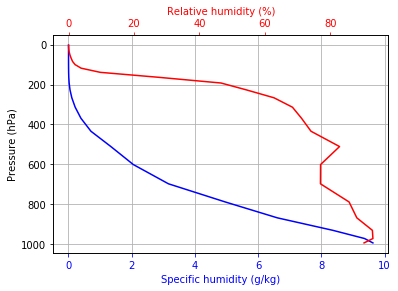

In [29]:
#  Plot relative humidity in percent
fig,ax = plt.subplots()
ax.plot(q*1000, rcm.lev, 'b-')
ax.invert_yaxis()
ax.grid()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (g/kg)', color='b')
ax.tick_params('x', colors='b')
ax2 = ax.twiny()
ax2.plot(rh*100., rcm.lev, 'r-')
ax2.set_xlabel('Relative humidity (%)', color='r')
ax2.tick_params('x', colors='r')

###  A radiative-convective model with fixed relative humidity

In [30]:
rcm_2xCO2_h2o = climlab.process_like(rcm_2xCO2)

In [31]:
for n in range(2000):
    # At every timestep
    # we calculate the new saturation specific humidity for the new temperature
    #  and change the water vapor in the radiation model
    #  so that relative humidity is always the same
    qsat = climlab.utils.thermo.qsat(rcm_2xCO2_h2o.Tatm, rcm_2xCO2_h2o.lev)
    rcm_2xCO2_h2o.subprocess['Radiation'].specific_humidity[:] = rh * qsat
    rcm_2xCO2_h2o.step_forward()

In [32]:
# Check for energy balance
rcm_2xCO2_h2o.ASR - rcm_2xCO2_h2o.OLR

Field([-1.63225368e-05])

What is the Equilibrium Climate Sensitivity of this new model?

In [33]:
ECS = rcm_2xCO2_h2o.Ts - rcm.Ts
ECS

Field([2.98970885])

With the water vapor feedback, doubling CO$_2$ causes 3 K of warming at equilibrium, rather than the no-feedback sensitivity of 1.3 K.

A pretty big difference!

The system gain is the ratio

In [34]:
g = ECS / ECS_nofeedback
g

Field([2.29822492])

So the moistening of the atmosphere more than doubles the global warming effect.

What about the feedback parameter?

This is just the ratio of the radiative forcing $\Delta R$ to the climate sensitivity:

In [35]:
lambda_net = DeltaR / ECS
lambda_net

Field([1.43397425])

The net feedback is $\lambda = 1.43$ W m$^{-2}$ K$^{-1}$.

Because of the additive nature of the feedbacks, this means that the individual contribution of the water vapor feedback is

$$ \lambda_{h2o} = \lambda_0 - \lambda $$

In [36]:
lambda_h2o = lambda0 - lambda_net
lambda_h2o

Field([1.86162112])

So we measure a water vapor feedback of $\lambda_{h2o} = 1.86$ W m$^{-2}$ K$^{-1}$.

This is a **positive number** consistent with the **amplifying effect** of the water vapor feedback.

The physical meaning of this number:

**For every 1 degree of surface warming, the increased water vapor greenhouse effect provides an additional 1.86 W m$^{-2}$ of radiative forcing.**

Compare back to the feedback figure from IPCC AR5. How does this analysis compare to the comprehensive GCMs? What is missing here?